### Motivation
降維可以幫助抵抗機器學習最常遇到的問題，龐大的維度規模。

#### MNIST digits database
手寫數位資料庫，握們使用Yann LeCun網站的資料集。
這個資料集可以分成三個子集合，50000實例的訓練集，10000實例驗證集，10000實力的測試集。所有的實例都已經有標籤了。

這資料集包含28x28 pixel的手寫圖片。每個單資料點(圖片)可以數字矩陣來傳送，數字代表著每pixel的深度。也就是28x28矩陣對應28x28 pixel圖。

我們可以平面化每個矩陣成28*28，784維度向量

向量中的每個元素都是0到1之間的浮點樹，代表每個pixel的強度。0是黑色1是白色。標籤號碼為0-9代表圖片中的數字

In [2]:
#import lib

import numpy as np 
import pandas as pd
import os,time
import pickle, gzip

#data viz
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
import matplotlib as mpl

# data prep and model evaluation
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

#algo
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

#### Load MNIST datasets


In [12]:
current_path = os.getcwd()
file = '\\datasets\\mnist_data\\mnist.pkl.gz'

f = gzip.open(current_path+file,'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()
validation_set

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([3, 8, 6, ..., 5, 6, 8], dtype=int64))

In [13]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0],validation_set[1]
X_test, y_test = test_set[0],test_set[1]

#### Verify shapeof datasets

In [14]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [34]:
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), len(X_train)+len(X_validation)+len(X_test))

In [35]:
X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.DataFrame(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.DataFrame(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.DataFrame(data=y_test, index=test_index)


#### Explore data


In [36]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.992188,0.992188,0.988281,0.988281,0.992188,0.242188,0.0,0.0,0.0,0.0


In [39]:
y_train

,0
0,5
1,0
2,4
3,1
4,9
...,...
49995,5
49996,0
49997,8
49998,4


In [53]:
def view_digit(example):
    label = y_train.loc[example]
    image = X_train.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d   Label: %d'%(example,label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

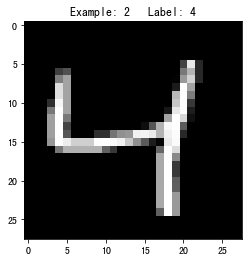

In [57]:
view_digit(2)

#### 線性投影 v.s. 流形學習
兩種最主要的降維分支。

線性投影:
從高維度將資料投影到低維度空間，
例子:<br/>PCA<br/> sigular value decomposition<br/> random projection<br/>

流形學習:
非線性降維，例如:<br/>isomap(學習兩點中曲線距離而非歐式距離)<br/>MDS(multidimensional scaling)<br/> Locally linear embedding(LLE)<br/> t-distributed stochastic neighbor embedding(t-SNE)<br/> dictionary learning
<br/>random trees embedding<br/> independent component analysis